In [1]:
import torch
from torch.utils.data import DataLoader

from rl4co.envs.scheduling.djssp.env import DJSSPEnv
from rl4co.envs.scheduling.djssp.render import render

if torch.cuda.is_available():
    accelerator = "gpu"
    batch_size = 256
    train_data_size = 2_000
    embed_dim = 128
    num_encoder_layers = 4
else:
    accelerator = "cpu"
    batch_size = 32
    train_data_size = 1_000
    embed_dim = 64
    num_encoder_layers = 2

C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
generator_params = {
    "num_jobs":6 ,
    "num_machines": 6 ,
    "min_processing_time":1 ,
    "max_processing_time": 99 ,
    "mtbf" : 40 ,
    "mttr" : 5
  }


from rl4co.envs import JSSPEnv



env = DJSSPEnv(generator_params=generator_params,stepwise_reward=True)

In [3]:
import gc
from rl4co.models.zoo.l2d.model import L2DPPOModel
from rl4co.models.zoo.l2d.policy import L2DPolicy4PPO
from torch.utils.data import DataLoader
import json
import os
from rl4co.utils.trainer import RL4COTrainer
import torch

# Policy: neural network, in this case with encoder-decoder architecture
policy = L2DPolicy4PPO(
    embed_dim=embed_dim,
    num_encoder_layers=num_encoder_layers,
    env_name="djsp",
    het_emb=False
)

model = L2DPPOModel(
    env=env,
    policy=policy,
    batch_size=batch_size,
    train_data_size=train_data_size,
    val_data_size=1_000,
    optimizer_kwargs={"lr": 1e-4}
)

C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
C:\Users\soner\anaconda3\envs\reinforce\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


In [4]:
td = env.reset(batch_size=[1])


In [5]:
print(type(td["machine_breakdowns"]))

<class 'numpy.ndarray'>


In [6]:
td["proc_times"][0]

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 67.0090,  0.0000,  0.0000,
          0.0000,  0.0000, 95.2113,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000, 74.1977,  0.0000,  0.0000,  0.0000,  0.0000, 74.1186,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, 47.3732,  0.0000,  0.0000,  0.0000,
          0.0000, 95.9491,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, 51.9462,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, 99.6337,  0.0000, 58.1511,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  8.1531,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  1.0642,  0.0000,  0.0000,  0.0000, 29.4183,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 65.3435,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.9922,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         84.2920,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 40.4173,
          0.0000,

In [7]:
td["machine_breakdowns"][0]

{0: [{'TIME': 54.75002670288086, 'DURATION': 3.7722136974334717},
  {'TIME': 72.0903890132904, 'DURATION': 7.5723772048950195},
  {'TIME': 147.87190294265747, 'DURATION': 5.235101222991943},
  {'TIME': 302.3248209953308, 'DURATION': 0.75322425365448},
  {'TIME': 607.9281233549118, 'DURATION': 7.498149394989014},
  {'TIME': 1224.4561235904694, 'DURATION': 0.056421998888254166},
  {'TIME': 2440.335784200579, 'DURATION': 0.6652746200561523},
  {'TIME': 4892.171494014561, 'DURATION': 2.8291196823120117}],
 1: [{'TIME': 10.474533081054688, 'DURATION': 2.44407320022583},
  {'TIME': 14.267833352088928, 'DURATION': 2.6660666465759277},
  {'TIME': 33.21631586551666, 'DURATION': 2.4496192932128906},
  {'TIME': 74.57199501991272, 'DURATION': 2.1153275966644287},
  {'TIME': 144.2104377746582, 'DURATION': 0.26548948884010315},
  {'TIME': 287.56660041213036, 'DURATION': 6.945370674133301},
  {'TIME': 591.9182164669037, 'DURATION': 0.2785354256629944},
  {'TIME': 1204.1383238434792, 'DURATION': 2.065

In [8]:
out = model.policy.generate(td.clone(), env=env, phase="test", decode_type="multistart_sampling", num_starts=100,  select_best=True)


before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before tensor(42.1763)
after tensor(52.7012)
THIS OPERATION 0
before t

In [9]:
out

{'reward': tensor([-665.8206]),
 'log_likelihood': tensor([-7.2643]),
 'actions': tensor([[1, 2, 1, 3, 5, 6, 4, 2, 1, 6, 3, 2, 5, 2, 4, 5, 5, 2, 1, 4, 4, 6, 1, 5,
          2, 4, 5, 3, 4, 1, 3, 3, 6, 3, 6, 6]]),
 'td': TensorDict(
     fields={
         action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False),
         action_mask: Tensor(shape=torch.Size([1, 7]), device=cpu, dtype=torch.bool, is_shared=False),
         actual_proc_times: Tensor(shape=torch.Size([1, 6, 36]), device=cpu, dtype=torch.float32, is_shared=False),
         adjacency: Tensor(shape=torch.Size([1, 36, 36]), device=cpu, dtype=torch.float32, is_shared=False),
         busy_until: Tensor(shape=torch.Size([1, 6]), device=cpu, dtype=torch.float32, is_shared=False),
         done: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.bool, is_shared=False),
         end_op_per_job: Tensor(shape=torch.Size([1, 6]), device=cpu, dtype=torch.int64, is_shared=False),
         finish_times: 

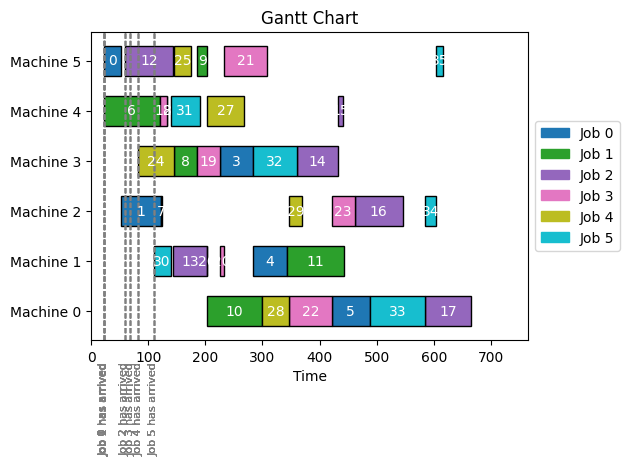

In [10]:
env.render(out["td"],0)

In [11]:
out["reward"]

tensor([-665.8206])

In [12]:
td = out["td"]


In [13]:
td["start_times"]

tensor([[ 22.3623,  52.7012, 132.3239, 225.3228, 283.7023, 421.1666,  22.8748,
         122.9552, 144.7531, 185.5897, 203.7103, 342.5939,  58.8254, 144.2617,
         359.8909, 432.2144, 461.5839, 584.1247, 119.9617, 185.5897, 225.3228,
         233.4759, 347.0480, 421.1666,  82.4465, 144.7531, 202.4128, 203.4769,
         298.9215, 347.0480, 109.6968, 139.1151, 283.7023, 488.1756, 584.1247,
         604.3317]])

In [14]:
td["machine_breakdowns"][0]

{0: [{'TIME': 54.75002670288086, 'DURATION': 3.7722136974334717},
  {'TIME': 72.0903890132904, 'DURATION': 7.5723772048950195},
  {'TIME': 147.87190294265747, 'DURATION': 5.235101222991943},
  {'TIME': 302.3248209953308, 'DURATION': 0.75322425365448},
  {'TIME': 607.9281233549118, 'DURATION': 7.498149394989014},
  {'TIME': 1224.4561235904694, 'DURATION': 0.056421998888254166},
  {'TIME': 2440.335784200579, 'DURATION': 0.6652746200561523},
  {'TIME': 4892.171494014561, 'DURATION': 2.8291196823120117}],
 1: [{'TIME': 10.474533081054688, 'DURATION': 2.44407320022583},
  {'TIME': 14.267833352088928, 'DURATION': 2.6660666465759277},
  {'TIME': 33.21631586551666, 'DURATION': 2.4496192932128906},
  {'TIME': 74.57199501991272, 'DURATION': 2.1153275966644287},
  {'TIME': 144.2104377746582, 'DURATION': 0.26548948884010315},
  {'TIME': 287.56660041213036, 'DURATION': 6.945370674133301},
  {'TIME': 591.9182164669037, 'DURATION': 0.2785354256629944},
  {'TIME': 1204.1383238434792, 'DURATION': 2.065

In [15]:
td["finish_times"]

tensor([[ 52.7012, 122.9552, 133.5079, 283.7023, 342.5939, 488.1756, 119.9617,
         123.9474, 185.5897, 203.7103, 298.9215, 442.2275, 144.2617, 202.4128,
         432.2144, 440.3195, 545.8759, 665.8206, 132.3239, 225.3228, 233.4759,
         308.6104, 421.1666, 461.5839, 144.7531, 175.4905, 203.4769, 267.7994,
         347.0480, 369.7095, 139.1151, 189.9894, 359.8909, 584.1247, 604.3317,
         616.1398]])

In [16]:
td["job_arrival_times"]

tensor([[ 22.3623,  22.8748,  58.8254,  68.7191,  82.4465, 109.6968]])

In [17]:
out["td"]["finish_times"]

tensor([[ 52.7012, 122.9552, 133.5079, 283.7023, 342.5939, 488.1756, 119.9617,
         123.9474, 185.5897, 203.7103, 298.9215, 442.2275, 144.2617, 202.4128,
         432.2144, 440.3195, 545.8759, 665.8206, 132.3239, 225.3228, 233.4759,
         308.6104, 421.1666, 461.5839, 144.7531, 175.4905, 203.4769, 267.7994,
         347.0480, 369.7095, 139.1151, 189.9894, 359.8909, 584.1247, 604.3317,
         616.1398]])